In [1]:
# 导包
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/dengruijun/data/FinTech/PP-Split/')
# 攻击
from ppsplit.HFL.DLG import DLGAttack
# 模型
from target_model.models.LeNet import LeNet, weights_init
from target_model.models.ImageClassification.ResNet import ResNet18
# utils
from ppsplit.utils.utils import create_dir

# 相似度评估
from ppsplit.utils.similarity_metrics import SimilarityMetrics
print(torch.__version__, torchvision.__version__)


1.12.1 0.13.1


In [2]:
# 参数
# parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
# parser.add_argument('--index', type=int, default="25",
#                     help='the index for leaking images on CIFAR.')
# parser.add_argument('--image', type=str,default="",
#                     help='the path to customized image.')
# args = parser.parse_args()

args = {'index':25,   # 试图恢复的图片的索引
        'dataset': 'CIFAR100',
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Running on %s" % device)
torch.manual_seed(1234) # 随机种子


Running on cuda:0


Files already downloaded and verified
84


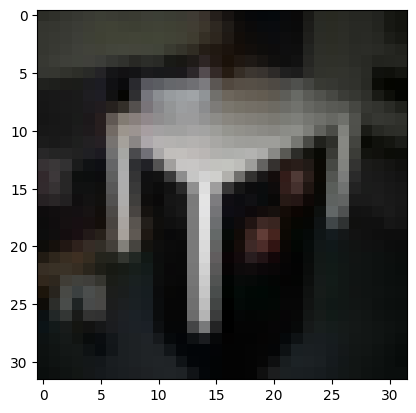

In [3]:
# 数据集模型加载
# cifar100 + LeNet

tt = transforms.ToTensor()
tp = transforms.ToPILImage()
# trainset = datasets.CIFAR100("/home/dengruijun/data/FinTech/DATASET/image-dataset/cifar100/", 
#                              train=True, download=True, transform=transforms.ToTensor())
trainset = datasets.CIFAR100("/home/dengruijun/data/FinTech/DATASET/image-dataset/cifar100/", 
                              download=True, transform=transforms.ToTensor())
# 取一张图片并展示原图
img_index = args['index']
data = trainset[img_index]
print(data[1])
plt.imshow(tp(data[0].cpu())) # 展示原始图片


# LeNet模型

In [4]:
# 模型加载
net = LeNet().to(device)
net.apply(weights_init)

LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
  )
)

In [22]:
#  攻击
dlg = DLGAttack() # 实例化攻击
[dummy_feature,dummy_label],history = dlg.reconstruct(net,data,NEpoch=300)


Iters:  0  Current Loss: 84.0807
Iters:  10  Current Loss: 4.6922
Iters:  20  Current Loss: 0.6442
Iters:  30  Current Loss: 0.1361
Iters:  40  Current Loss: 0.0454
Iters:  50  Current Loss: 0.0237
Iters:  60  Current Loss: 0.0148
Iters:  70  Current Loss: 0.0101
Iters:  80  Current Loss: 0.0076
Iters:  90  Current Loss: 0.0060
Iters:  100  Current Loss: 0.0053
Iters:  110  Current Loss: 0.0039
Iters:  120  Current Loss: 0.0033
Iters:  130  Current Loss: 0.0029
Iters:  140  Current Loss: 248.5978
Iters:  150  Current Loss: 248.5978
Iters:  160  Current Loss: 248.5978
Iters:  170  Current Loss: 248.5978
Iters:  180  Current Loss: 248.5978
Iters:  190  Current Loss: 248.5978
Iters:  200  Current Loss: 248.5978
Iters:  210  Current Loss: 248.5978
Iters:  220  Current Loss: 248.5978
Iters:  230  Current Loss: 248.5978
Iters:  240  Current Loss: 248.5978
Iters:  250  Current Loss: 248.5978
Iters:  260  Current Loss: 248.5978
Iters:  270  Current Loss: 248.5978
Iters:  280  Current Loss: 248

In [27]:
# similarity 评估
from torchvision import models, datasets, transforms

sim = SimilarityMetrics(type=1) # 图像数据
dummy_feature_best = transforms.ToTensor()(history[13])
raw_feature = data[0].to(dummy_feature_best.device)
sim.collect_sim_img(raw_feature,dummy_feature_best,None)
sim.report_similarity()
print(raw_feature.mean())
print(dummy_feature_best.mean())

average euc: 1.2471675872802734
average mse: 0.07257286459207535
average ssim: 0.5510901808738708
tensor(0.1902)
tensor(0.2770)


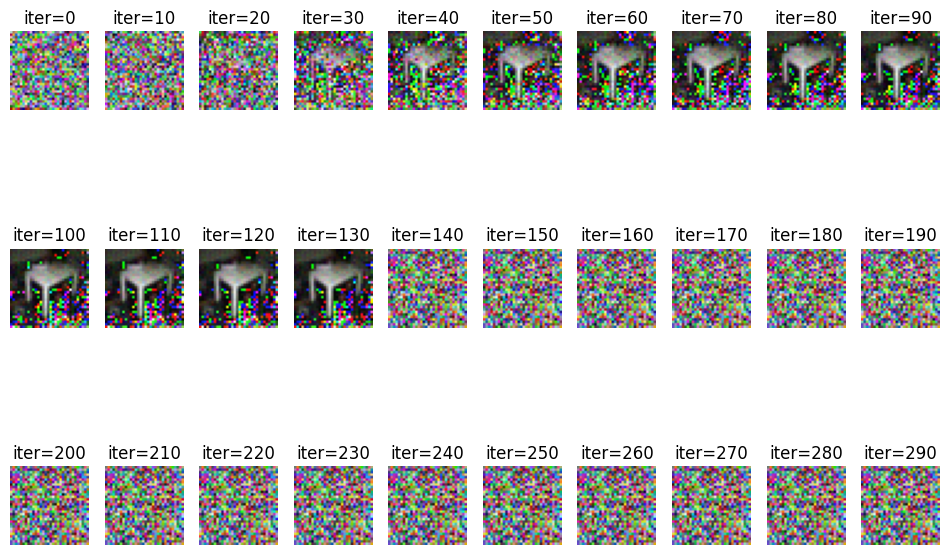

In [24]:
# 画出攻击过程迭代图
dlg.show_optimization_process(history)

# ResNet模型

6
features.0.weight
features.0.bias
features.1.weight
features.1.bias
features.1.running_mean
features.1.running_var
features.1.num_batches_tracked
features.4.weight
features.4.bias
features.5.weight
features.5.bias
features.5.running_mean
features.5.running_var
features.5.num_batches_tracked
features.8.weight
features.8.bias
features.9.weight
features.9.bias
features.9.running_mean
features.9.running_var
features.9.num_batches_tracked
denses.0.weight
denses.0.bias
denses.1.weight
denses.1.bias


<All keys matched successfully>

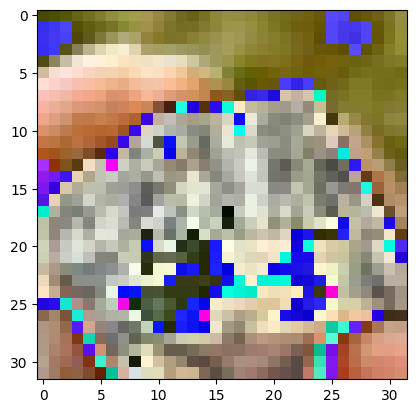

In [7]:
# 数据集
from target_model.data_preprocessing.preprocess_cifar10 import get_cifar10_normalize,get_one_data,deprocess
from target_model.models.ImageClassification.VGG5_9 import VGG,VGG5Decoder,model_cfg
from target_model.models.splitnn_utils import split_weights_client

train_loader,test_loader = get_cifar10_normalize(batch_size=1)
trainset = train_loader.dataset

# 取一张图片并展示原图
img_index = args['index']
data = trainset[img_index]
print(data[1])
plt.imshow(tp(data[0].cpu())) # 展示原始图片

# 模型加载b
# net = ResNet18().to(device)
# net.apply(weights_init)
split_layer = 6 # 模型切割点 （split point）在该层之前的层（含），作为client的模型，之后的层作为server的模型
unit_net_route = '/home/dengruijun/data/FinTech/PP-Split/results/trained_models/VGG5/BN+Tanh/VGG5-params-20ep.pth'

net = VGG('Client','VGG5',split_layer,model_cfg)
pweights = torch.load(unit_net_route)
if split_layer < len(model_cfg['VGG5']):
    pweights = split_weights_client(pweights,net.state_dict())
net.load_state_dict(pweights)

In [8]:
#  攻击
dlg = DLGAttack(num_class=10) # 实例化攻击
[dummy_feature,dummy_label],history = dlg.reconstruct(net,data,NEpoch=300)


Iters:  0  Current Loss: 16760.5801
Iters:  10  Current Loss: 12323.8311
Iters:  20  Current Loss: 12323.8311
Iters:  30  Current Loss: 12323.8311
Iters:  40  Current Loss: 12323.8311
Iters:  50  Current Loss: 12323.8311
Iters:  60  Current Loss: 12323.8311
Iters:  70  Current Loss: 12323.8311
Iters:  80  Current Loss: 12323.8311
Iters:  90  Current Loss: 12323.8311
Iters:  100  Current Loss: 12323.8311
Iters:  110  Current Loss: 12323.8311
Iters:  120  Current Loss: 12323.8311
Iters:  130  Current Loss: 12323.8311
Iters:  140  Current Loss: 12323.8311
Iters:  150  Current Loss: 12323.8311
Iters:  160  Current Loss: 12323.8311
Iters:  170  Current Loss: 12323.8311
Iters:  180  Current Loss: 12323.8311
Iters:  190  Current Loss: 12323.8311
Iters:  200  Current Loss: 12323.8311
Iters:  210  Current Loss: 12323.8311
Iters:  220  Current Loss: 12323.8311
Iters:  230  Current Loss: 12323.8311
Iters:  240  Current Loss: 12323.8311
Iters:  250  Current Loss: 12323.8311
Iters:  260  Current Lo

In [ ]:
# 画出攻击过程迭代图
dlg.show_optimization_process(history)